In [1]:
!pip install pygro

In [2]:
from google.colab import files
uploaded = files.upload()

Saving tab_gillessen_pos.csv to tab_gillessen_pos.csv
Saving tab_gillessen_vr.csv to tab_gillessen_vr.csv


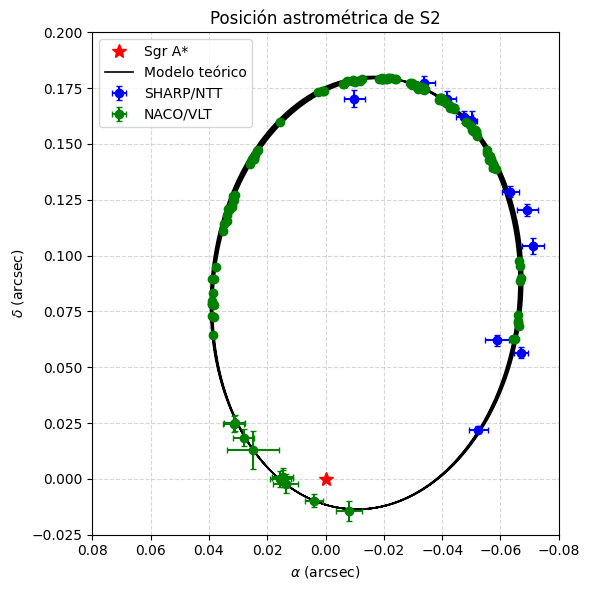

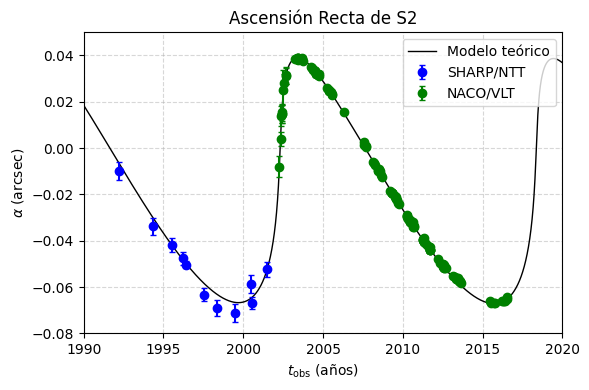

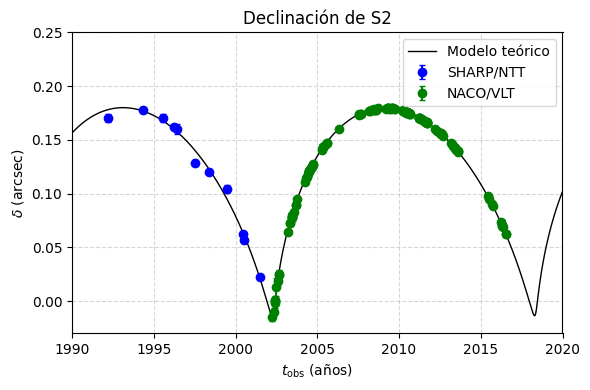

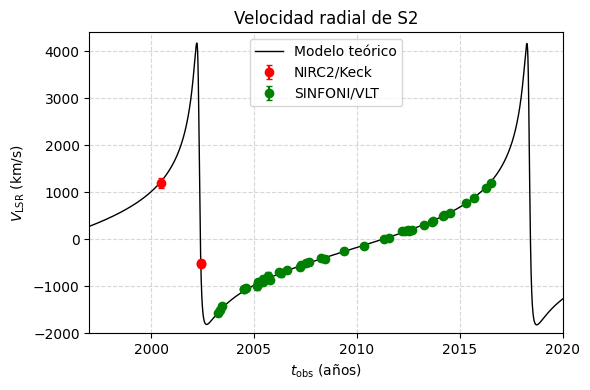

In [14]:


from google.colab import files
uploaded = files.upload()

from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy import constants, units
import pygro

# Definimos las constantes a usar en el codigo
Msun = units.Msun.to('kg') * units.kg
r_G = (constants.G * 4.35241e6 * Msun / constants.c**2).to('au').value

# Definimos los parámetros orbitales de S2 (en este caso usamos los datos para el mejor ajuste)
D = 8.31  # Distancia al centro de la galaxia medido en kpc
t_p = 2002.32 # Año del periastro
a = 0.125 # Semieje mayor en arcseg
e = 0.885 # excintricidad
inc = np.deg2rad(134.69) #inclinacion orbital
Omega = np.deg2rad(227.79) #longitud del nodo ascendente
omega = np.deg2rad(65.72) #Argumento del periastro

# Convertimos cantidades a las unidades apropiadas

D_s = D * units.kpc.to('au')
a_sma = a * units.arcsec.to('rad') * D_s / r_G
T = np.sqrt(4 * np.pi**2 * a_sma**3)

#Cargamos los datos experimentales de la posicion y velocidad de S2
pos = pd.read_csv("tab_gillessen_pos.csv", names = ["t", "alpha", "alpha_err", "delta", "delta_err"])
rv = pd.read_csv("tab_gillessen_vr.csv", names = ["t", "v_los", "vlos_err"])
t_pos = pos.t.values
alpha_obs = pos.alpha.values/1000
delta_obs = pos.delta.values/1000
alpha_err = pos.alpha_err.values/1000
delta_err = pos.delta_err.values/1000
t_rv = rv.t.values
vlos_obs = rv.v_los.values
vlos_err = rv.vlos_err.values

# Definimos la métrica a usar, en este caso la de Schwarzschild
metric = pygro.Metric(
    name="Schwarzschild spacetime",
    coordinates=["t", "r", "theta", "phi"],
    line_element="-(1-2*M/r)*dt**2+1/(1-2*M/r)*dr**2+(r**2)*(dtheta**2+sin(theta)**2*dphi**2)",
    transform=[
        "t",
        "r*sin(theta)*cos(phi)",
        "r*sin(theta)*sin(phi)",
        "r*cos(theta)"
    ],
    M=1
)

# Motor de geodésicas (el cual se encarga de resolver las ecuaciones)

geo_engine = pygro.GeodesicEngine(integrator="dp45")
geo_engine.set_stopping_criterion("r > 2.001*M", "horizon")

# Definimos los parametros de nuestra orbita (condiciones iniciales) e inicializamos el motor para resolver las ecuaciones.
# Resolvemos las ecauciones para atras y para adelanta

orbit_fw = pygro.Orbit(geo_engine=geo_engine)
orbit_fw.set_orbital_parameters(t_P=0, a=a_sma, e=e, i=inc, omega=omega, Omega=Omega)
orbit_fw.integrate(2*T, 1, accuracy_goal=24, precision_goal=24, direction="fw")

orbit_bw = pygro.Orbit(geo_engine=geo_engine)
orbit_bw.set_orbital_parameters(t_P=0, a=a_sma, e=e, i=inc, omega=omega, Omega=Omega)
orbit_bw.integrate(2*T, 1, accuracy_goal=24, precision_goal=24, direction="bw")

# Transformamos a coordenadas observables
def orbit_to_observables(orbit):

        t, x, y, z = metric.transform(orbit.geo.x.T)

        # Pasamos el tiempo a años

        t_em = t_p+t*r_G/constants.c.to('au/yr').value

        # Consideramos el efecto Rømer

        t_obs = t_em+z*r_G/constants.c.to('au/yr').value

        # Pasamos a unidades astrometricas

        alpha = y*r_G/D_s*units.rad.to('arcsec')
        delta = x*r_G/D_s*units.rad.to('arcsec')

        # Velocidad de la línea de visión y corrimiento al rojo longitudinal

        v_z = orbit.geo.u[:,1]*np.cos(orbit.geo.x[:,2])-orbit.geo.x[:,1]*orbit.geo.u[:,2]*np.sin(orbit.geo.x[:,2])
        longitudinal_redshift = v_z

        # redshift gravitacional

        einstein_redshift = orbit.geo.u[:,0]-1

        # velocidad total de la linea de vision

        redshift = (longitudinal_redshift+1)*(einstein_redshift+1)-1
        v_los = redshift*constants.c.to('km/s')

        return t_obs, alpha, delta, v_los

# combinamos los datos obtenidos de la solucion hacia adelante y hacia atras

t_obs_bw, alpha_bw, delta_bw, v_los_bw = orbit_to_observables(orbit_bw)
t_obs_fw, alpha_fw, delta_fw, v_los_fw = orbit_to_observables(orbit_fw)

t_obs = np.hstack([np.flip(t_obs_bw), t_obs_fw])
alpha = np.hstack([np.flip(alpha_bw), alpha_fw])
delta = np.hstack([np.flip(delta_bw), delta_fw])
v_los = np.hstack([np.flip(v_los_bw), v_los_fw])

phi_vals = np.hstack([np.flip(orbit_bw.geo.x[:, 3]), orbit_fw.geo.x[:, 3]])
ur_vals = np.hstack([np.flip(orbit_bw.geo.u[:, 1]), orbit_fw.geo.u[:, 1]])


# Separamos por instrumento según el año (posición)
sharp_mask = t_pos < 2002
naco_mask = ~sharp_mask

# Separamos por instrumento según el año (velocidad radial)
keck_mask = t_rv < 2003
sinfoni_mask = ~keck_mask

# === GRÁFICA 1: RA vs Dec ===
plt.figure(figsize=(6, 6))
plt.plot([0.], [0.], '*', ms=10., color='red', label='Sgr A*')
plt.plot(alpha, delta, '-', color='black', lw=1.2, label="Modelo teórico")
plt.errorbar(alpha_obs[sharp_mask], delta_obs[sharp_mask], xerr=alpha_err[sharp_mask], yerr=delta_err[sharp_mask],
             fmt='bo', capsize=2, label='SHARP/NTT')
plt.errorbar(alpha_obs[naco_mask], delta_obs[naco_mask], xerr=alpha_err[naco_mask], yerr=delta_err[naco_mask],
             fmt='go', capsize=2, label='NACO/VLT')
plt.xlabel(r'$\alpha$ (arcsec)')
plt.ylabel(r'$\delta$ (arcsec)')
plt.title("Posición astrométrica de S2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(0.08, -0.08)
plt.ylim(-0.025, 0.2)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# === GRÁFICA 2: RA vs tiempo ===
plt.figure(figsize=(6, 4))
plt.plot(t_obs, alpha, '-', color='black', lw=1, label="Modelo teórico")
plt.errorbar(t_pos[sharp_mask], alpha_obs[sharp_mask], yerr=alpha_err[sharp_mask],
             fmt='bo', capsize=2, label='SHARP/NTT')
plt.errorbar(t_pos[naco_mask], alpha_obs[naco_mask], yerr=alpha_err[naco_mask],
             fmt='go', capsize=2, label='NACO/VLT')
plt.xlabel(r'$t_{\rm obs}$ (años)')
plt.ylabel(r'$\alpha$ (arcsec)')
plt.title("Ascensión Recta de S2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(1990, 2020)
plt.ylim(-0.08, 0.05)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# === GRÁFICA 3: Dec vs tiempo ===
plt.figure(figsize=(6, 4))
plt.plot(t_obs, delta, '-', color='black', lw=1, label="Modelo teórico")
plt.errorbar(t_pos[sharp_mask], delta_obs[sharp_mask], yerr=delta_err[sharp_mask],
             fmt='bo', capsize=2, label='SHARP/NTT')
plt.errorbar(t_pos[naco_mask], delta_obs[naco_mask], yerr=delta_err[naco_mask],
             fmt='go', capsize=2, label='NACO/VLT')
plt.xlabel(r'$t_{\rm obs}$ (años)')
plt.ylabel(r'$\delta$ (arcsec)')
plt.title("Declinación de S2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(1990, 2020)
plt.ylim(-0.03, 0.25)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# === GRÁFICA 4: Velocidad radial ===
plt.figure(figsize=(6, 4))
plt.plot(t_obs, v_los, '-', color='black', lw=1, label="Modelo teórico")
plt.errorbar(t_rv[keck_mask], vlos_obs[keck_mask], yerr=vlos_err[keck_mask],
             fmt='ro', capsize=2, label='NIRC2/Keck')
plt.errorbar(t_rv[sinfoni_mask], vlos_obs[sinfoni_mask], yerr=vlos_err[sinfoni_mask],
             fmt='go', capsize=2, label='SINFONI/VLT')
plt.xlabel(r'$t_{\rm obs}$ (años)')
plt.ylabel(r'$V_{\rm LSR}$ (km/s)')
plt.title("Velocidad radial de S2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(1997, 2020)
plt.ylim(-2000, 4400)
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()


